1533953074.8007748
Starting LightGBM. Train shape: (307511, 227), test shape: (48744, 227)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.719707	valid_1's auc: 0.722513
[200]	training's auc: 0.731641	valid_1's auc: 0.733291
[300]	training's auc: 0.740128	valid_1's auc: 0.740531
[400]	training's auc: 0.74567	valid_1's auc: 0.745102
[500]	training's auc: 0.749355	valid_1's auc: 0.748081
[600]	training's auc: 0.752278	valid_1's auc: 0.750261
[700]	training's auc: 0.754515	valid_1's auc: 0.751983
[800]	training's auc: 0.756448	valid_1's auc: 0.753438
[900]	training's auc: 0.758062	valid_1's auc: 0.754536
[1000]	training's auc: 0.759506	valid_1's auc: 0.755526
[1100]	training's auc: 0.76067	valid_1's auc: 0.756262
[1200]	training's auc: 0.761808	valid_1's auc: 0.757003
[1300]	training's auc: 0.762804	valid_1's auc: 0.757573
[1400]	training's auc: 0.7637	valid_1's auc: 0.758089
[1500]	training's auc: 0.764556	valid_1's auc: 0.758567
[1600]	training's a

[3200]	training's auc: 0.776749	valid_1's auc: 0.753985
[3300]	training's auc: 0.777221	valid_1's auc: 0.754103
[3400]	training's auc: 0.777658	valid_1's auc: 0.754217
[3500]	training's auc: 0.778109	valid_1's auc: 0.754324
[3600]	training's auc: 0.778558	valid_1's auc: 0.754431
[3700]	training's auc: 0.778999	valid_1's auc: 0.75453
[3800]	training's auc: 0.779413	valid_1's auc: 0.754584
[3900]	training's auc: 0.779834	valid_1's auc: 0.754647
[4000]	training's auc: 0.780212	valid_1's auc: 0.754686
[4100]	training's auc: 0.780622	valid_1's auc: 0.754782
[4200]	training's auc: 0.781019	valid_1's auc: 0.754853
[4300]	training's auc: 0.781413	valid_1's auc: 0.754901
[4400]	training's auc: 0.781816	valid_1's auc: 0.754966
[4500]	training's auc: 0.782217	valid_1's auc: 0.755021
[4600]	training's auc: 0.78261	valid_1's auc: 0.75511
[4700]	training's auc: 0.782973	valid_1's auc: 0.755146
[4800]	training's auc: 0.783343	valid_1's auc: 0.755191
[4900]	training's auc: 0.783704	valid_1's auc: 0.75

[3900]	training's auc: 0.778119	valid_1's auc: 0.760376
[4000]	training's auc: 0.778581	valid_1's auc: 0.760438
[4100]	training's auc: 0.779049	valid_1's auc: 0.760516
[4200]	training's auc: 0.779486	valid_1's auc: 0.760576
[4300]	training's auc: 0.779906	valid_1's auc: 0.760585
[4400]	training's auc: 0.780342	valid_1's auc: 0.760616
[4500]	training's auc: 0.780763	valid_1's auc: 0.760654
[4600]	training's auc: 0.781166	valid_1's auc: 0.760701
[4700]	training's auc: 0.78156	valid_1's auc: 0.760719
[4800]	training's auc: 0.781938	valid_1's auc: 0.760739
[4900]	training's auc: 0.782336	valid_1's auc: 0.760788
[5000]	training's auc: 0.782698	valid_1's auc: 0.760814
[5100]	training's auc: 0.783073	valid_1's auc: 0.760895
[5200]	training's auc: 0.783469	valid_1's auc: 0.760932
[5300]	training's auc: 0.783821	valid_1's auc: 0.760939
[5400]	training's auc: 0.784205	valid_1's auc: 0.760937
Early stopping, best iteration is:
[5256]	training's auc: 0.783669	valid_1's auc: 0.760963
Fold  5 AUC : 

AttributeError: 'float' object has no attribute 'strftime'

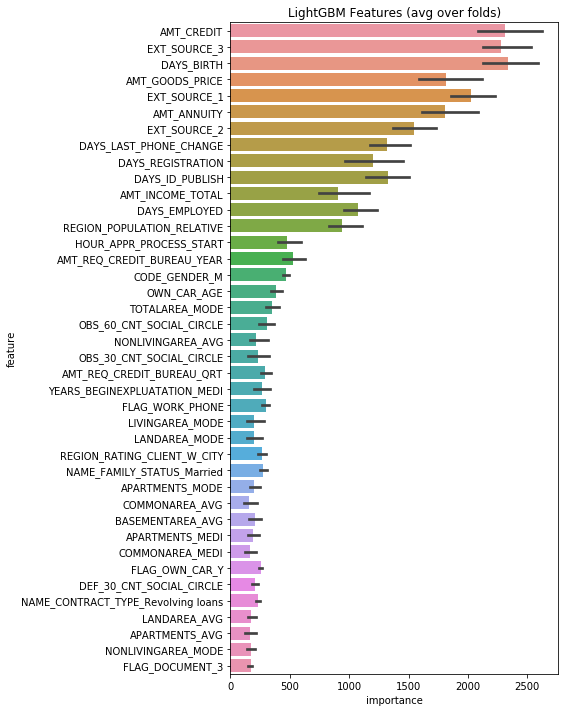

In [30]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables.
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).

# You can use LightGBM with KFold or Stratified KFold. Please upvote if you find usefull, thanks!

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

PATH ='../../data'

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code

def kfold_lightgbm(train_df, test_df, num_folds, stratified=False, debug=False):

    # Divide in training/validation and test data
    #train_df = df[df['TARGET'].notnull()]
    #test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    #del df
    gc.collect()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns 
             if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000, #10000
            learning_rate=0.01,
            num_leaves=50,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=3, #8
            reg_alpha=0.00, #.001
            reg_lambda=0.01,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, 
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc', 
                verbose=100, 
                early_stopping_rounds=200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, 
                                                 num_iteration=clf.best_iteration_)[:, 1]
        
        sub_preds += clf.predict_proba(test_df[feats], 
                                       num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

    return feature_importance_df


# Display/plot feature importance
def display_importances(feature_importance_df_, save=True):
    
    cols = feature_importance_df_[["feature", "importance"]]\
    .groupby("feature")\
    .mean()\
    .sort_values(by="importance",
                 ascending=False)[:40]\
    .index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

    if (save):
        dt = time.time()
        plt.savefig('lgbm_importances_{0}.png'.format(dt.strftime("%Y%m%d_%H%M%S")))


def main(debug=True, num_folds=2):

    # df = pd.read_pickle('combined_data.pkl')
    df_train = pd.read_csv('application_train.csv')
    df_test = pd.read_csv('application_test.csv')
    
    ## START DM ##
    
    # Train# 
    
    # NULL COLUMNS
    has_null = [col for col in df_train.columns 
                if sum(df_train[col].isnull())]
    
    # numerical
    has_null_num = [col for col in has_null 
                    if df_train[col].dtype == 'float']
    
    # categorical
    has_null_cat = [col for col in has_null 
                    if df_train[col].dtype == 'object']
    
    # IMPUTE
    # impute with mean
    for col in has_null_num:
        df_train[col] = df_train[col].fillna(df_train[col].mean())
    # impute with default value
    # for col in has_null_cat:
        # df[col] = df[col].fillna('unknown_'+col)
        
    # ENCODING
    col_cat = [col for col in df_train.columns
               if df_train[col].dtype == 'object']
    
    for col in col_cat:
        dummy = pd.get_dummies(df_train[col], 
                               prefix=col, 
                               drop_first=True)    

        df_train = df_train.join(dummy)
    
    del dummy
    gc.collect()
    df_train = df_train.drop(col_cat, axis=1)
    
    # Test #  
    
    # NULL COLUMNS
    has_null = [col for col in df_test.columns 
                if sum(df_test[col].isnull())]
    
    # numerical
    has_null_num = [col for col in has_null 
                    if df_test[col].dtype == 'float']
    
    # categorical
    has_null_cat = [col for col in has_null 
                    if df_test[col].dtype == 'object']
    
    # IMPUTE
    # impute with mean
    for col in has_null_num:
        df_test[col] = df_test[col].fillna(df_test[col].mean())
    # impute with default value
    # for col in has_null_cat:
        # df[col] = df[col].fillna('unknown_'+col)
        
    # ENCODING
    col_cat = [col for col in df_test.columns
               if df_test[col].dtype == 'object']
   
    for col in col_cat:
        dummy = pd.get_dummies(df_test[col], 
                               prefix=col, 
                               drop_first=True)    

        df_test = df_test.join(dummy)
    
    del dummy
    gc.collect()
    df_test = df_test.drop(col_cat, axis=1)
    
    df_test['TARGET'] = 0
    missing_list = list(set(df_train.columns) - set(df_test.columns))
    df_train = df_train.drop(missing_list, axis=1)
    
    ## END DM ##
    
    with timer("Run LightGBM plus kfold {0}".format(num_folds)):
        feature_importance_df = kfold_lightgbm(df_train, df_test, num_folds=5, stratified=False, debug=debug)
        display_importances(feature_importance_df)

if __name__ == "__main__":
    print("{0}".format(time.time()))
    with timer("Full model run"):
        main()